In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mp
# import gaia_tools as gt
import scipy
from scipy.ndimage import gaussian_filter
import astropy.units as u
from astropy.coordinates import SkyCoord
import math

In [2]:
# reading in simulation data about the LMC cdm wake
stars = np.load('C:/Users/dnurm/Desktop/Uni_files/Thesis/.venv/Data/star_particles_pos_5e8.npy') # change to local path depending on whether you're using home PC / laptop
starsdf = pd.DataFrame(stars)
starsdf = starsdf.rename(columns={0:"x", 1:"y", 2:"z"})

# to remove outliers in the z axis with np.where, I first need to convert the column to a numeric type with pd.to_numeric.
# z axis is chosen specifically because, if the data is plotted in the x-z axis, the relevant data is clearly bound between -20 and 20 kpc.
# This 

starsdf["z"] = pd.to_numeric(starsdf["z"], errors="coerce")
starsdf['z'] = np.where((starsdf['z'] > 20) | (starsdf['z'] < -20), np.nan, starsdf['z'])
starsdf = starsdf.dropna(subset=["z"])

x_s = starsdf['x']
y_s = starsdf['y']
z_s = starsdf['z']

large_cloud = np.array([x_s, y_s, z_s])

bins = (35, 35)

In [3]:
file = 'C:/Users/dnurm/Desktop/Uni_files/Thesis/.venv/Data/trajlmc.txt'

orbit = pd.read_csv(file, delimiter=' ')

In [4]:
orbit

,time,x,y,z,Vx,Vy,Vz
0,-5.000000,19.9294,339.6150,216.0000,6.31562,18.17450,-38.8996
1,-4.875000,20.7107,341.7090,211.0270,6.18473,15.32570,-40.6646
2,-4.750000,21.4753,343.4450,205.8350,6.04658,12.44010,-42.4002
3,-4.625000,22.2221,344.8180,200.4280,5.90088,9.51268,-44.1082
4,-4.500000,22.9501,345.8210,194.8090,5.74725,6.53814,-45.7909
...,...,...,...,...,...,...,...
428,0.218750,-13.3517,-70.9110,21.8903,-49.71050,-77.45880,209.6100
429,0.226562,-13.7372,-71.5090,23.5140,-48.99090,-75.64540,206.0510
430,0.234375,-14.1172,-72.0944,25.1088,-48.27500,-74.21250,202.2240
431,0.242188,-14.4915,-72.6701,26.6727,-47.56420,-73.17590,198.1270


In [5]:
df_test = pd.DataFrame({(0, -45, -45), 
                   (0, 200, -200),
                   (0, 500, 140)}, 
#},
                  columns=['x', 'y', 'z'])

x_test = df_test['x']
y_test = df_test['y']
z_test = df_test['z']

In [6]:
# Mock wake generator
def generate_mock_wake(
    
    N_total=300_000,
    box_half_size=300.0,                 # kpc; box is [-L, L]^3
    f_overdense=0.25,                    # fraction of particles in wake component
    mu=(-30.0, 5.0, 0.0),                # kpc; wake center (x0, y0, z0)
    sigma_major=100.0,                    # kpc; wake length-scale along major axis
    sigma_minor=50.0,                    # kpc; width in the orthogonal in-plane axis
    sigma_z=8.0,                         # kpc; thickness
    theta_deg=0.0,                       # rotation of wake in XY plane (deg)
    rng_seed=7
):
    """
    Return a structured ndarray with fields: x,y,z,component (1=wake, 0=bg).
    """
    rng = np.random.default_rng(rng_seed)
    N_over = int(N_total * f_overdense)
    N_bg   = N_total - N_over
    mu = np.asarray(mu, dtype=float)

    # Rotation in the XY plane
    theta = np.deg2rad(theta_deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s],
                  [s,  c]])

    # Covariance in XY for the anisotropic Gaussian
    Lambda_xy = np.diag([sigma_major**2, sigma_minor**2])
    Sigma_xy  = R @ Lambda_xy @ R.T

    # Wake samples
    xy_over = rng.multivariate_normal(mean=mu[:2], cov=Sigma_xy, size=N_over)
    z_over  = rng.normal(loc=mu[2], scale=sigma_z, size=N_over)

    # Clip to keep inside box
    xy_over[:, 0] = np.clip(xy_over[:, 0], -box_half_size, box_half_size)
    xy_over[:, 1] = np.clip(xy_over[:, 1], -box_half_size, box_half_size)
    z_over        = np.clip(z_over,        -box_half_size, box_half_size)

    # Uniform background
    x_bg = rng.uniform(-box_half_size, box_half_size, size=N_bg)
    y_bg = rng.uniform(-box_half_size, box_half_size, size=N_bg)
    z_bg = rng.uniform(-box_half_size, box_half_size, size=N_bg)

    # Concatenate positions
    x = np.concatenate([xy_over[:, 0], x_bg])
    y = np.concatenate([xy_over[:, 1], y_bg])
    z = np.concatenate([z_over,        z_bg])

    # Pack catalog
    comp = np.concatenate([np.ones(N_over, dtype=np.int8),
                           np.zeros(N_bg, dtype=np.int8)])  # 1=wake, 0=bg
    

    cat = np.zeros(N_total, dtype=[('x','f4'),('y','f4'),('z','f4'),('component','i1')])
    
    cat['x'], cat['y'], cat['z']   = x, y, z
    cat['component'] = comp
    return cat


In [7]:
result = generate_mock_wake()
result

array([( -29.876986,   19.937277,    1.949072 , 1),
       ( -57.413784,  -39.52959 ,   -2.6321273, 1),
       ( -75.46708 ,  -44.58233 ,   -4.129546 , 1), ...,
       ( -67.989845,  105.101776, -265.415    , 0),
       (-194.56839 , -122.20985 , -250.83775  , 0),
       ( 215.33652 ,  -90.41174 , -102.19617  , 0)],
      dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('component', 'i1')])

In [8]:
df = pd.DataFrame(result)
df
coords = df[['x', 'y', 'z']].values

In [9]:
# 3D rotation matrixes
def rx(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[1, 0, 0],
                     [0, c,-s],
                     [0, s, c]])
def ry(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[ c, 0, s],
                     [ 0, 1, 0],
                     [-s, 0, c]])
def rz(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c,-s, 0],
                     [s, c, 0],
                     [0, 0, 1]])

def rotate(rot_mat, vec):
    return rot_mat @ vec


In [10]:
# testing whether rotation matrices work
tiben = rotate([300, 0, 0], rz((np.pi/2)))  
tiben 

array([ 1.8369702e-14, -3.0000000e+02,  0.0000000e+00])

In [11]:
tiben2 = rotate(ry(np.pi/2), [300, 0, 0])
tiben2

array([ 1.8369702e-14,  0.0000000e+00, -3.0000000e+02])

Exercise: test rotation function with 2 points around z axis to check how it works with more than 1 points. Check how python rotations more than one point basically. 

Test how numpy works while applying a scalar mult. to a set of vectors?

Look into: https://numpy.org/doc/stable/user/basics.broadcasting.html

In [12]:
# Current task is to try and rotate the entire set of points around a certain axis.

In [13]:
#test array 
x = np.linspace(0, 1, 10)
y = np.zeros(10)
z = np.zeros(10)

test_array = np.array([x, y, z])

x_2 = np.linspace(0, 1, 2)
y_2 = np.zeros(2)
z_2 = np.zeros(2)
test_array_2 = np.array([x_2, y_2, z_2])



In [14]:
rot_1 = rotate(rz(np.pi/2), test_array)
rot_3 = rotate(rz(np.pi/4), test_array)


In [15]:
rot_2 = rotate(rz(np.pi/2), test_array_2)

In [16]:
rot_2

array([[0.000000e+00, 6.123234e-17],
       [0.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00]])

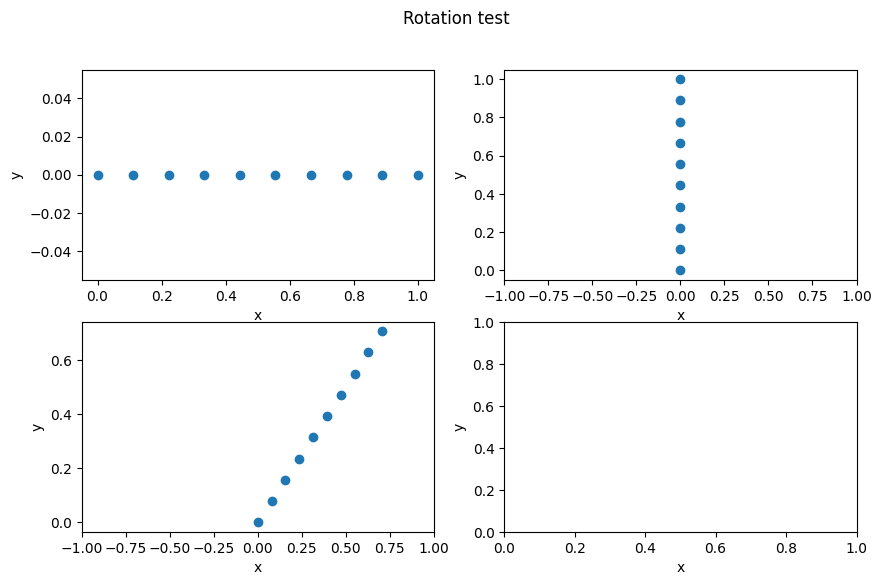

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle('Rotation test')

axs[0, 0].scatter(test_array[0], test_array[1])


axs[0, 1].scatter(rot_1[0], rot_1[1])
axs[0, 1].set_xlim(-1, 1) 

axs[1, 0].scatter(rot_3[0], rot_3[1])
axs[1, 0].set_xlim(-1, 1) 

for ax in axs.flat:
    ax.set(xlabel='x', ylabel='y')

In [18]:
large_cloud.shape

(3, 44760982)

In [19]:
extent = [-60, 60, -60, 60]
def plot_OD_gaussian(x, y, bins, sigma): # x coord, y coord, nr of bins, extent of plot, sigma for gaussian filter
    fig,ax = plt.subplots()
    
    def overdensity(x, y, bins):  # generating the overdensity map
        pre_OD, xedges, yedges = np.histogram2d(x, y, bins)
        OD = (pre_OD / np.mean(pre_OD)-1)
        return OD, xedges, yedges
    
    OD, xedges, yedges = overdensity(x, y, bins) # calling out the function
    im = ax.imshow(OD.T, origin='lower', cmap = "seismic")
    c = plt.colorbar(im, ax=ax)
    plt.title("Star simulation x, y | bins = "+ str(bins))
    plt.xlabel("x (kpc)")
    plt.ylabel("y (kpc)")
    c.set_label('difference from average star density', rotation=270, labelpad=20)
    hist_smoothed = gaussian_filter(OD.T, sigma=sigma)
    image = plt.imshow(hist_smoothed, origin='lower', extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="seismic")
    return image

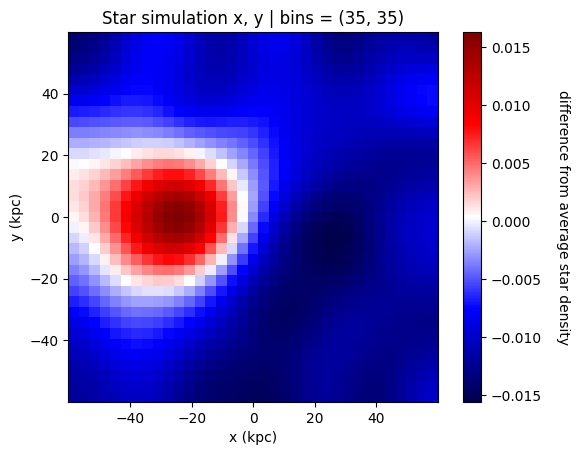

In [20]:
plot_OD_gaussian(x_s, y_s, (35, 35), 3)

In [21]:
x_sim = result['x']
y_sim = result['y']
z_sim = result['z']

sim = np.array([x_sim, y_sim, z_sim])

In [22]:
print(max(x_sim))
print(min(x_sim))

300.0
-300.0


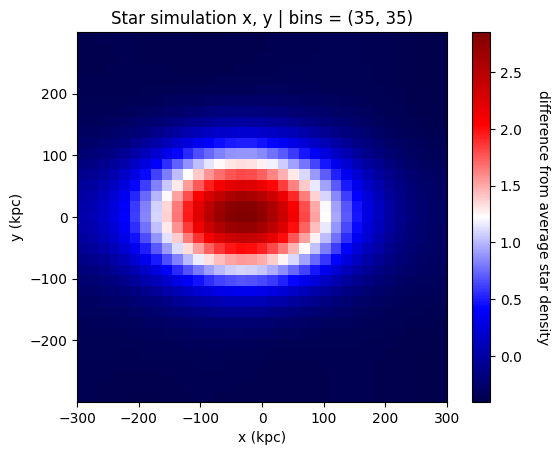

In [23]:
plot_OD_gaussian(x_sim, y_sim, (35, 35), 3)

In [24]:
sim_rot = rotate(rz(np.pi/2), sim)

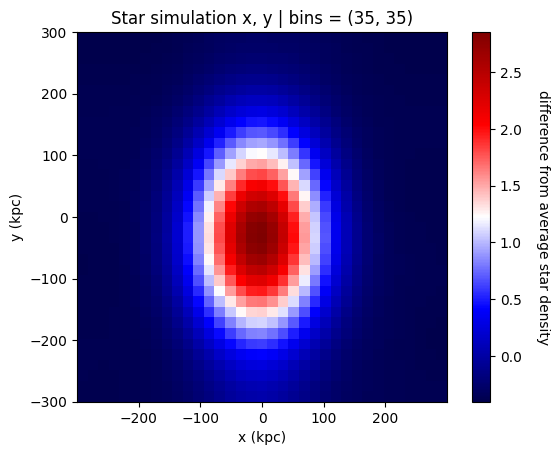

In [25]:
plot_OD_gaussian(sim_rot[0], sim_rot[1], (35, 35), 3)

In [26]:
# through trial and error I found out, the current day position of the LMC is at row index 400. 
today_orbit = orbit.iloc[400]

today = np.array([today_orbit['Vx'], today_orbit['Vy'], today_orbit['Vz']])
today = today 
origin = np.array([today_orbit['x'], today_orbit['y'], today_orbit['z']])



vx, vy, vz = today_orbit['Vx'], today_orbit['Vy'], today_orbit['Vz']
factor = 50  # how long you want the arrow in kpc-units space
length = (vx**2 + vy**2 + vz**2)**0.5
Ux, Uy, Uz = vx/length * factor, vy/length * factor, vz/length * factor
speed = np.array([Ux, Uy, Uz]) 


In [27]:
print(Ux, Uy, Uz)

-10.497552788465145 -35.212291860532986 33.91011482407616


In [28]:
print(speed)
print(today)
print(origin)

[-10.49755279 -35.21229186  33.91011482]
[ -63.9522 -214.517   206.584 ]
[ -0.561918 -40.7118   -27.177   ]


In [84]:
def angle_between(v1, v2):
    v1_v2 = np.dot(v1, v2)
    mag_v1 = np.linalg.norm(v1)
    mag_v2 = np.linalg.norm(v2)
    angle_Z = np.arccos(v1_v2 / (mag_v1 * mag_v2))
    return np.degrees(angle_Z)

In [ ]:
#Horrible logic below, needs to be fixed. Unfortunately it works


v21 = np.array([300, 0, 0])
v21xy = np.array([300, 0])
todayxy = np.array([speed[0], speed[1]])

j = angle_between(v21xy, todayxy)

rot = rotate(rz(math.radians(-j)), v21)

rot

peanut = angle_between(rot, speed)
peanut

np.float64(42.70332336631607)

In [91]:
# line along the x axis
line1 = np.array([np.linspace(-300, 300, 3), np.zeros(3), np.zeros(3)])

# # line3 = rotate(rz(np.pi/2), line)
# # line2 = rotate(ry(np.pi/6), line3)
# line2 = line.T + origin
# line2 = line2.T

In [94]:
R = (rz(math.radians(-j)) @ ry(math.radians(-peanut)))
line2 = R @ line1

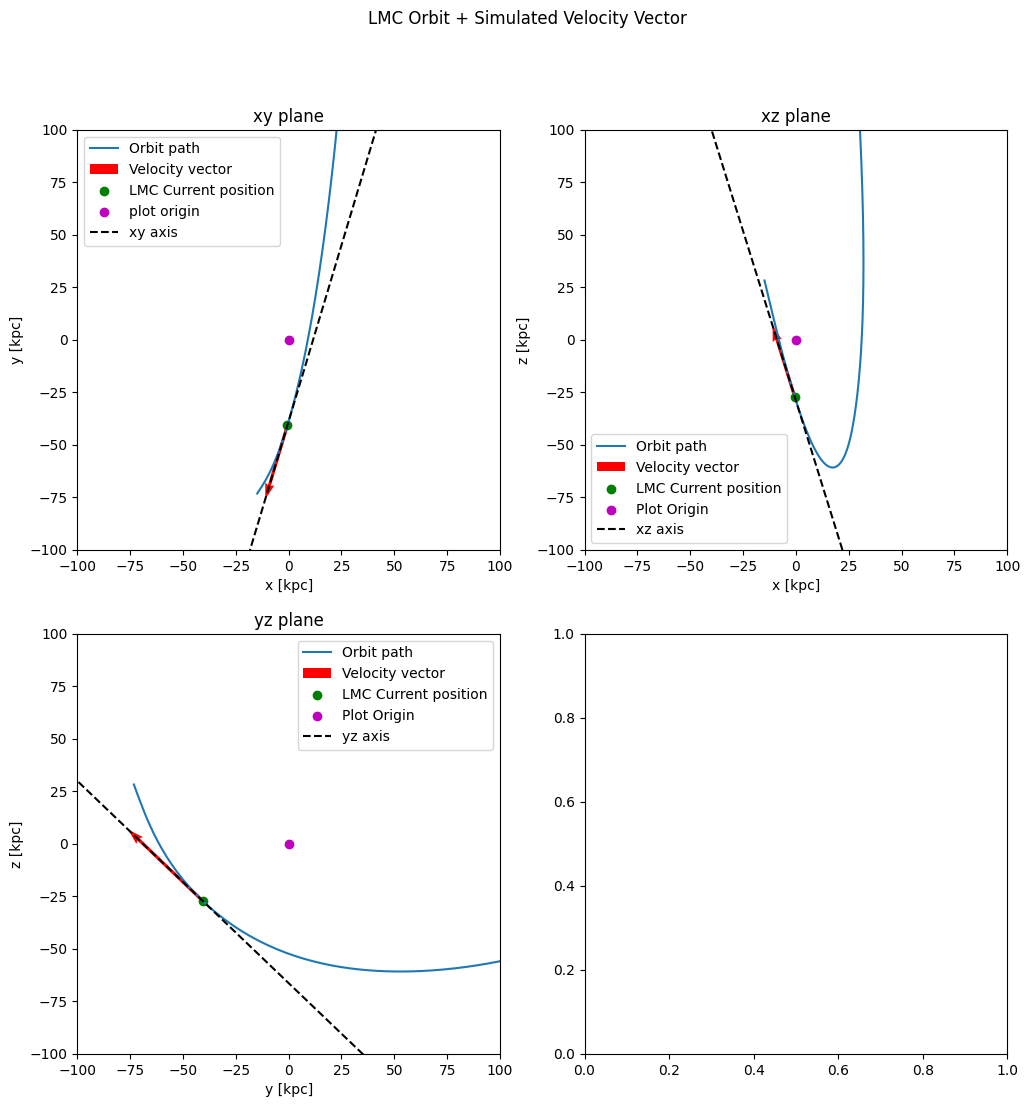

In [105]:
# Visualizing velocity vectors on the orbit to see what direction I need to rotate the simulations
#xy, xz, yz axis refers to the x axis line as seen on the respective 2D views. xy axis means the x axis line as seen depicted on the xy plot, etc. 

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('LMC Orbit + Simulated Velocity Vector')

axs[0, 0].plot(orbit['x'], orbit['y'])
#axs[0, 0].quiver(origin[0], origin[1], today[0] * 30000000, today[1] * 30000000, angles='xy', scale_units='xy', color='r',  width=0.009)
axs[0,0].quiver(
    origin[0], origin[1],
    Ux, Uy,
    angles='xy', scale_units='xy', scale=1,
    pivot='tail', color='r'
)
axs[0,0].set_title('xy plane')
axs[0,0].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,0].set_xlim(-100, 100)
axs[0,0].set_ylim(-100, 100)
axs[0, 0].scatter(origin[0], origin[1], color='g', label='Current position')
axs[0, 0].scatter(0, 0, color='m', label='Plot Origin')
axs[0, 0].plot(line2[0]+origin[0], line2[1]+origin[1], color='black', linestyle='dashed', label='xy axis')
axs[0,0].legend(['Orbit path', 'Velocity vector', 'LMC Current position', 'plot origin', 'xy axis'])



axs[0, 1].plot(orbit['x'], orbit['z'])
axs[0,1].set_xlim(-100, 100)
axs[0,1].set_ylim(-100, 100)
axs[0,1].quiver(
    origin[0], origin[2],
    Ux, Uz,
    angles='xy', scale_units='xy', scale=1,
    pivot='tail', color='r'
)
axs[0,1].set_title('xz plane')
axs[0,1].set_xlabel('x [kpc]')
axs[0,1].set_ylabel('z [kpc]')
axs[0, 1].scatter(origin[0], origin[2], color='g', label='Current position')
axs[0, 1].scatter(0, 0, color='m', label='Plot Origin')
axs[0, 1].plot(line2[0]+origin[0], line2[2]+origin[2], color='black', linestyle='dashed', label='xz axis')
axs[0, 1].legend(['Orbit path', 'Velocity vector', 'LMC Current position', 'Plot Origin', 'xz axis'])


axs[1, 0].plot(orbit['y'], orbit['z'])
axs[1,0].set_xlim(-100, 100)
axs[1,0].set_ylim(-100, 100)
axs[1, 0].quiver(
    origin[1], origin[2],
    Uy, Uz,
    angles='xy', scale_units='xy', scale=1,
    pivot='tail', color='r'
)
axs[1,0].set_title('yz plane')
axs[1,0].set_xlabel('y [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1, 0].scatter(origin[1], origin[2], color='g', label='Current position')
axs[1, 0].scatter(0, 0, color='m', label='Plot Origin')
axs[1, 0].plot(line2[1]+origin[1], line2[2]+origin[2], color='black', linestyle='dashed', label='yz axis')
axs[1, 0].legend(['Orbit path', 'Velocity vector', 'LMC Current position', 'Plot Origin', 'yz axis'])


In [33]:
v1 = np.array([np.sqrt(2), 0, 0])
v2 = np.array([-1, 1, 1])
v1_xy = np.array([np.sqrt(2), 0])
v1_xz = np.array([np.sqrt(2), 0])
v1_yz = np.array([0, 0])
v2_xy = np.array([-1, 1])
v2_xz = np.array([-1, 1])
v2_yz = np.array([1, 1])


In [34]:
R = rz(math.radians(135)) @ ry(math.radians(-35.26))
line12 = R @ line1


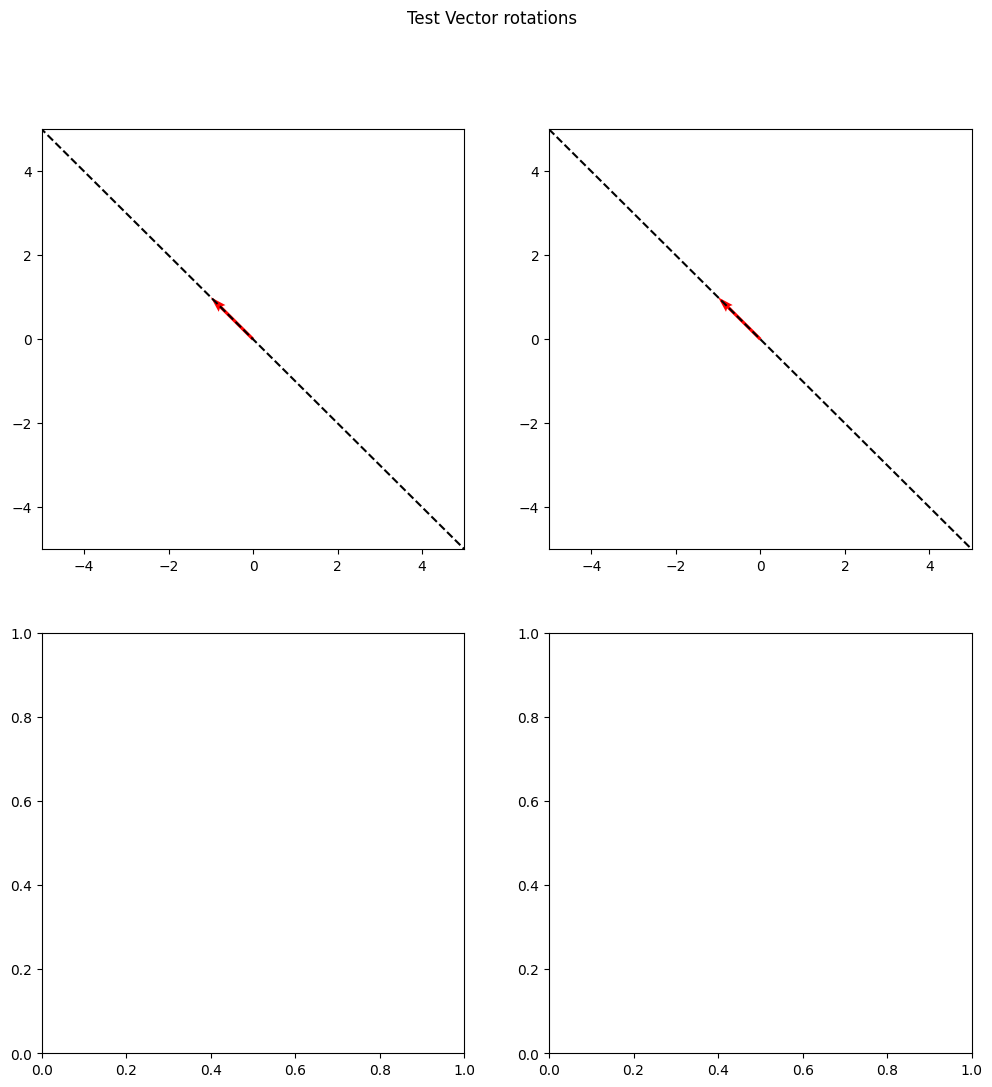

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Test Vector rotations')

axs[0,0].quiver(
    0, 0,
    -1, 1,
    angles='xy', scale_units='xy', scale=1,
    pivot='tail', color='r'
)
axs[0,0].set_xlim(-5, 5)
axs[0,0].set_ylim(-5, 5)
axs[0,0].plot(line12[0], line12[1], color='black', linestyle='dashed', label='xz axis')



axs[0,1].quiver(
    0, 0,
    -1, 1,
    angles='xy', scale_units='xy', scale=1,
    pivot='tail', color='r'
)
axs[0,1].set_xlim(-5, 5)
axs[0,1].set_ylim(-5, 5)
axs[0,1].plot(line12[0], line12[2], color='black', linestyle='dashed', label='xz axis')

# axs[0, 1].plot(orbit['x'], orbit['z'])
# axs[0,1].set_xlim(-100, 100)
# axs[0,1].set_ylim(-100, 100)
# axs[0,1].quiver(
#     origin[0], origin[2],
#     Ux, Uz,
#     angles='xy', scale_units='xy', scale=1,
#     pivot='tail', color='r'
# )
# axs[0, 1].scatter(origin[0], origin[2], color='g', label='Current position')
# axs[0, 1].scatter(0, 0, color='m', label='Plot Origin')
# axs[0, 1].plot(line2[0], line2[2], color='black', linestyle='dashed', label='xz axis')
# axs[0, 1].legend(['Orbit path', 'Velocity vector', 'LMC Current position', 'Plot Origin', 'xz axis'])


# axs[1, 0].plot(orbit['y'], orbit['z'])
# axs[1,0].set_xlim(-100, 100)
# axs[1,0].set_ylim(-100, 100)
# axs[1, 0].quiver(
#     origin[1], origin[2],
#     Uy, Uz,
#     angles='xy', scale_units='xy', scale=1,
#     pivot='tail', color='r'
# )
# axs[1, 0].scatter(origin[1], origin[2], color='g', label='Current position')
# axs[1, 0].scatter(0, 0, color='m', label='Plot Origin')
# axs[1, 0].plot(line2[1], line2[2], color='black', linestyle='dashed', label='yz axis')
# axs[1, 0].legend(['Orbit path', 'Velocity vector', 'LMC Current position', 'Plot Origin', 'yz axis'])


# for ax in axs.flat:
#     ax.set(xlabel='kpc', ylabel='kpc')

In [36]:
a = np.array([1, 0, 0])

f =rz(math.radians(135)) @ a

np.float64(106.60046723806266)

102.1194840042244
